In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

# std libs
from pathlib import Path
import sys, importlib

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("ggplot")
mpl.rcParams.update({"figure.dpi": 300, "figure.figsize": (12, 6)})

# paths: root = this file/notebook folder
try:
    here = Path(__file__).resolve().parent   # .py files
except NameError:
    here = Path.cwd().resolve()              # notebooks

root    = here                                # ← same location
scripts = root / "scripts"
if str(scripts) not in sys.path:
    sys.path.insert(0, str(scripts))          # ensure your modules are found first

# dev-friendly reload while keeping import *
def _reload_star(mod_names):
    importlib.invalidate_caches()
    for name in mod_names:
        if name in sys.modules:
            del sys.modules[name]

_mods = ["plot_config", "timeseries_functions", "seepage_analysis", "seepage_plots"]
_reload_star(_mods)

# keep star-imports as requested
from plot_config import *
from timeseries_functions import *
from seepage_analysis import *
from seepage_plots import *

data_path = root / "data"

hypso = pd.read_excel(data_path / "RR_stage_storage.xlsx", header=3)


In [24]:


summary_pos = pd.read_csv(data_path / 'summary_pos.csv')
summary_pos['date'] = pd.to_datetime(summary_pos['date'])

In [25]:
summary_pos[['date', 'Ks', 'CI_low', 'CI_high']].head()

,date,Ks,CI_low,CI_high
0,2012-07-14,1.374,0.871630,1.876617
1,2012-10-08,0.647,0.285723,1.007982
2,2013-06-10,0.448,0.371432,0.524177
3,2013-09-29,0.309,0.148344,0.469827
4,2014-01-14,0.309,0.252747,0.364253


In [26]:
# Reload the Excel file using your method and ensure compatibility
file_path = data_path / 'Goat Rock beach dimensions.xlsx'
excel_data = pd.ExcelFile(file_path)

# Combine data from all sheets into one DataFrame
combined_data = pd.DataFrame()

for sheet_name in excel_data.sheet_names:
    data = excel_data.parse(sheet_name)
    data['Sheet'] = sheet_name[-1]  # Add a column to indicate the sheet name
    combined_data = pd.concat([combined_data, data], ignore_index=True)

# Convert the 'date' column to datetime format
combined_data['date'] = pd.to_datetime(combined_data['date'])
combined_data = combined_data.rename({'crest elev ' : 'crest elev'}, axis = 1)

In [27]:
import pandas as pd
import numpy as np

# Load the data
# summary_pos_path = 'summary_pos.csv'
# goat_rock_path = 'Goat Rock beach dimensions.xlsx'

# summary_pos = pd.read_csv(summary_pos_path)[['date', 'Ks', 'CI_low', 'CI_high']]
# goat_rock = pd.read_excel(goat_rock_path)

# # Calculate the median for transect data
goat_rock = combined_data.groupby('date')[['width 10', 'width 12', 
                            'width 14', 'crest elev']].median().reset_index()
# goat_rock = transects_med

# Convert the 'date' columns to datetime format
summary_pos['date'] = pd.to_datetime(summary_pos['date'])
goat_rock['date'] = pd.to_datetime(goat_rock['date'])

# Sort both dataframes by date
summary_pos = summary_pos.sort_values(by='date').reset_index(drop=True)
goat_rock = goat_rock.sort_values(by='date').reset_index(drop=True)

# Add a column to track used rows in summary_pos
summary_pos['used'] = False

# Maximum allowed days for matching
max_days = 5
tolerance = pd.Timedelta(days=max_days)

# Initialize the results list
results = []

# Iterate through each Goat Rock date and find the closest unmatched summary_pos date
for gr_date in goat_rock['date']:
    # Filter unused rows in summary_pos within the tolerance range
    candidates = summary_pos[~summary_pos['used'] & (abs(summary_pos['date'] - gr_date) <= tolerance)]

    if not candidates.empty:
        # Find the closest date
        closest_row = candidates.iloc[(candidates['date'] - gr_date).abs().argsort().iloc[0]]
        
        # Mark the closest row as used
        # summary_pos.loc[closest_row.name, 'used'] = True
        
        # Append the result with the matched data
        results.append({
            'date': gr_date,
            'Ks': closest_row['Ks'],
            'CI_low': closest_row['CI_low'],
            'CI_high': closest_row['CI_high'],
            'days_difference': abs((closest_row['date'] - gr_date).days)
        })

# Create a dataframe from the results
matched_data = pd.DataFrame(results)

# # Merge the matched data back with goat_rock
result = goat_rock.merge(matched_data, on='date', how='inner')

len(result.Ks.unique())
result.dropna()[['width 10', 'width 12', 'width 14', 'crest elev', 'Ks']].corr('spearman').round(2)

,width 10,width 12,width 14,crest elev,Ks
width 10,1.00,0.96,0.83,0.82,-0.40
width 12,0.96,1.00,0.88,0.84,-0.40
width 14,0.83,0.88,1.00,0.89,-0.35
crest elev,0.82,0.84,0.89,1.00,-0.33
Ks,-0.40,-0.40,-0.35,-0.33,1.00


In [28]:


summary_pos['date'] = pd.to_datetime(summary_pos['date'])
goat_rock['date'] = pd.to_datetime(goat_rock['date'])

# Sort both dataframes by date
summary_pos = summary_pos.sort_values(by='date').reset_index(drop=True)
goat_rock = goat_rock.sort_values(by='date').reset_index(drop=True)


# Maximum allowed days for matching
max_days = 10
tolerance = pd.Timedelta(days=max_days)

# Initialize the results list
results = []

# Iterate through each summary_pos row and find the closest Goat Rock date
for sp_row in summary_pos.itertuples():
    sp_date = sp_row.date
    
    # Filter Goat Rock rows within the tolerance range
    candidates = goat_rock[abs(goat_rock['date'] - sp_date) <= tolerance]
    
    if not candidates.empty:
        # Find the closest date
        closest_row = candidates.iloc[(candidates['date'] - sp_date).abs().argsort().iloc[0]]
        
        # Append the result with the matched data
        results.append({
            'date': sp_date,
            'Ks': sp_row.Ks,
            'CI_low': sp_row.CI_low,
            'CI_high': sp_row.CI_high,
            'days_difference': abs((closest_row['date'] - sp_date).days),
            'width 10': closest_row['width 10'],
            'width 12': closest_row['width 12'],
            'width 14': closest_row['width 14'],
            'crest elev': closest_row['crest elev']
        })
# Create a dataframe from the results
matched_data = pd.DataFrame(results)

matched_data.dropna()[['width 10', 'width 12', 'width 14', 'crest elev', 'Ks']].corr('spearman').round(2)

,width 10,width 12,width 14,crest elev,Ks
width 10,1.00,0.97,0.87,0.86,-0.39
width 12,0.97,1.00,0.92,0.89,-0.41
width 14,0.87,0.92,1.00,0.93,-0.37
crest elev,0.86,0.89,0.93,1.00,-0.37
Ks,-0.39,-0.41,-0.37,-0.37,1.00


In [29]:
root

PosixPath('/Users/octaviacrompton/Google_Drive_quatratavia/estuaries_jenner/russian-river-seepage')

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload the Excel file and ensure compatibility
file_path = 'data/Goat Rock beach dimensions.xlsx'
excel_data = pd.ExcelFile(file_path)

# Combine data from all sheets into one DataFrame
combined_data = pd.DataFrame()

for sheet_name in excel_data.sheet_names:
    data = excel_data.parse(sheet_name)
    data['Sheet'] = sheet_name[-1]  # Add a column to indicate the sheet name
    combined_data = pd.concat([combined_data, data], ignore_index=True)

# Convert the 'date' column to datetime format
combined_data['date'] = pd.to_datetime(combined_data['date'])
combined_data = combined_data.rename({'crest elev ': 'crest elev'}, axis=1)

# Load and preprocess summary_pos data
summary_pos_path = 'data/summary_pos.csv'
summary_pos = pd.read_csv(summary_pos_path)
summary_pos['date'] = pd.to_datetime(summary_pos['date'])

# Perform an outer join on 'date'
merged_df = pd.merge(combined_data, summary_pos, on='date', how='outer')

# Compute the max, min, and median of 'crest elev' across sheets
merged_df['crest elev'] = pd.to_numeric(merged_df['crest elev'], errors='coerce')
merged_df['crest elev'] = (merged_df['crest elev'] - 2.73) * 0.3048  # Convert NGVD29 to NAVD88 and feet to meters
merged_df['year'] = merged_df.date.dt.year
merged_df = merged_df.query('year > 2012 and year < 2023')




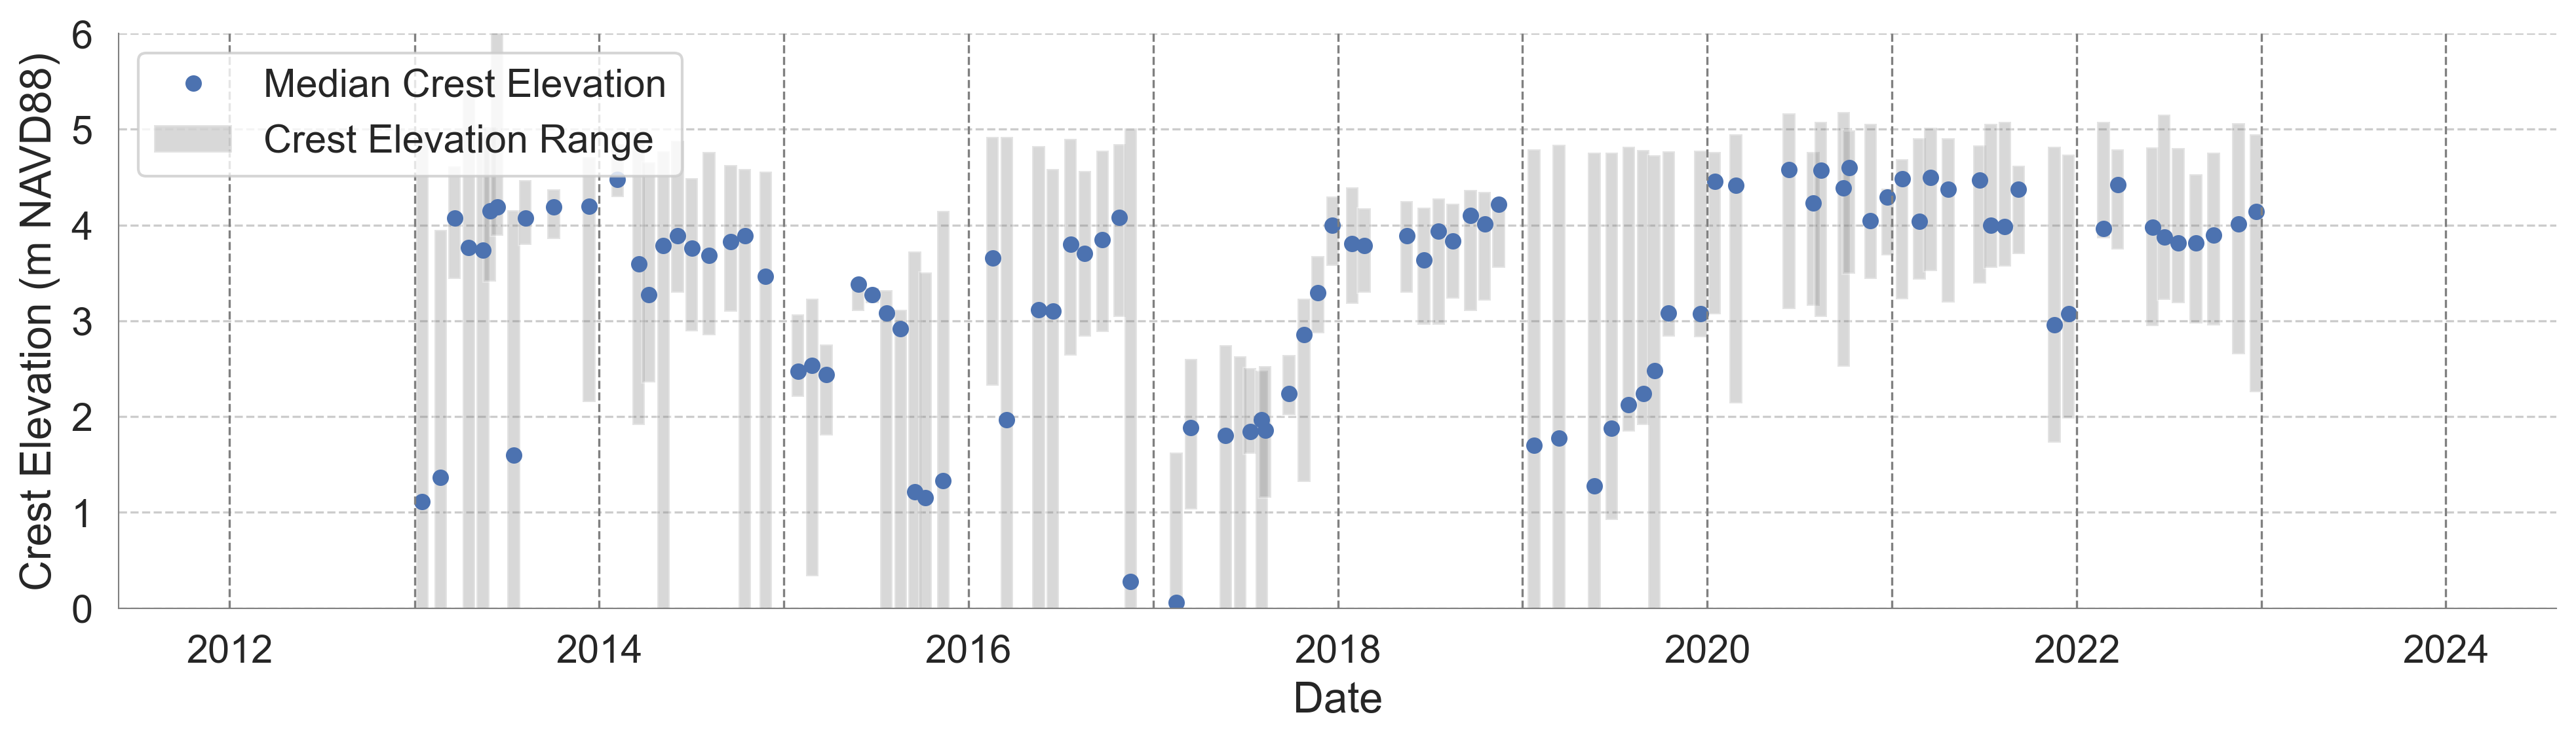

In [31]:
crest_stats = merged_df.groupby('date')['crest elev'].agg(['min', 'max', 'median']).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(16, 3.8))

# Plot the bar for crest elevation range
ax1.bar(
    crest_stats['date'], 
    crest_stats['max'] - crest_stats['min'], 
    bottom=crest_stats['min'], 
    width=25, 
    color='grey', 
    alpha=0.3,
    label='Crest Elevation Range'
)
ax1.plot(
    crest_stats['date'], 
    crest_stats['median'],
    'o', markersize = 5, color = 'C0', 
    label='Median Crest Elevation'
)

# Configure primary axis for crest elevation
ax1.set_xlabel('Date')
ax1.set_ylabel('Crest Elevation (m NAVD88)')
# ax1.set_title('Beach Crest Elevation and Ks Over Time', fontsize=14, weight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.4,linewidth=0.8)
ax1.legend(loc='upper left')
ax1.set_ylim(0, 6)
# # Create twin axis for Ks
# ax2 = ax1.twinx()
# ax2.plot(
#     summary_pos['date'], 
#     summary_pos['Ks'],
#     'C1o', 
#     alpha=0.7,
#     label='Ks'
# )
# ax2.set_ylabel('Ks (m/s)', fontsize=12)
# ax2.legend(loc='upper right')

# ax2.set_ylim(0,1.6)
# ax1.set_ylim(0,6)


# Identify the range of years
start_year =  2012
end_year = 2024

# Add vertical lines for every May
for year in range(start_year, end_year + 1):
    ax1.axvline(pd.to_datetime(f'{year}-01-01'), color='grey', linestyle='--', linewidth=0.8)


(0.0, 1.8)

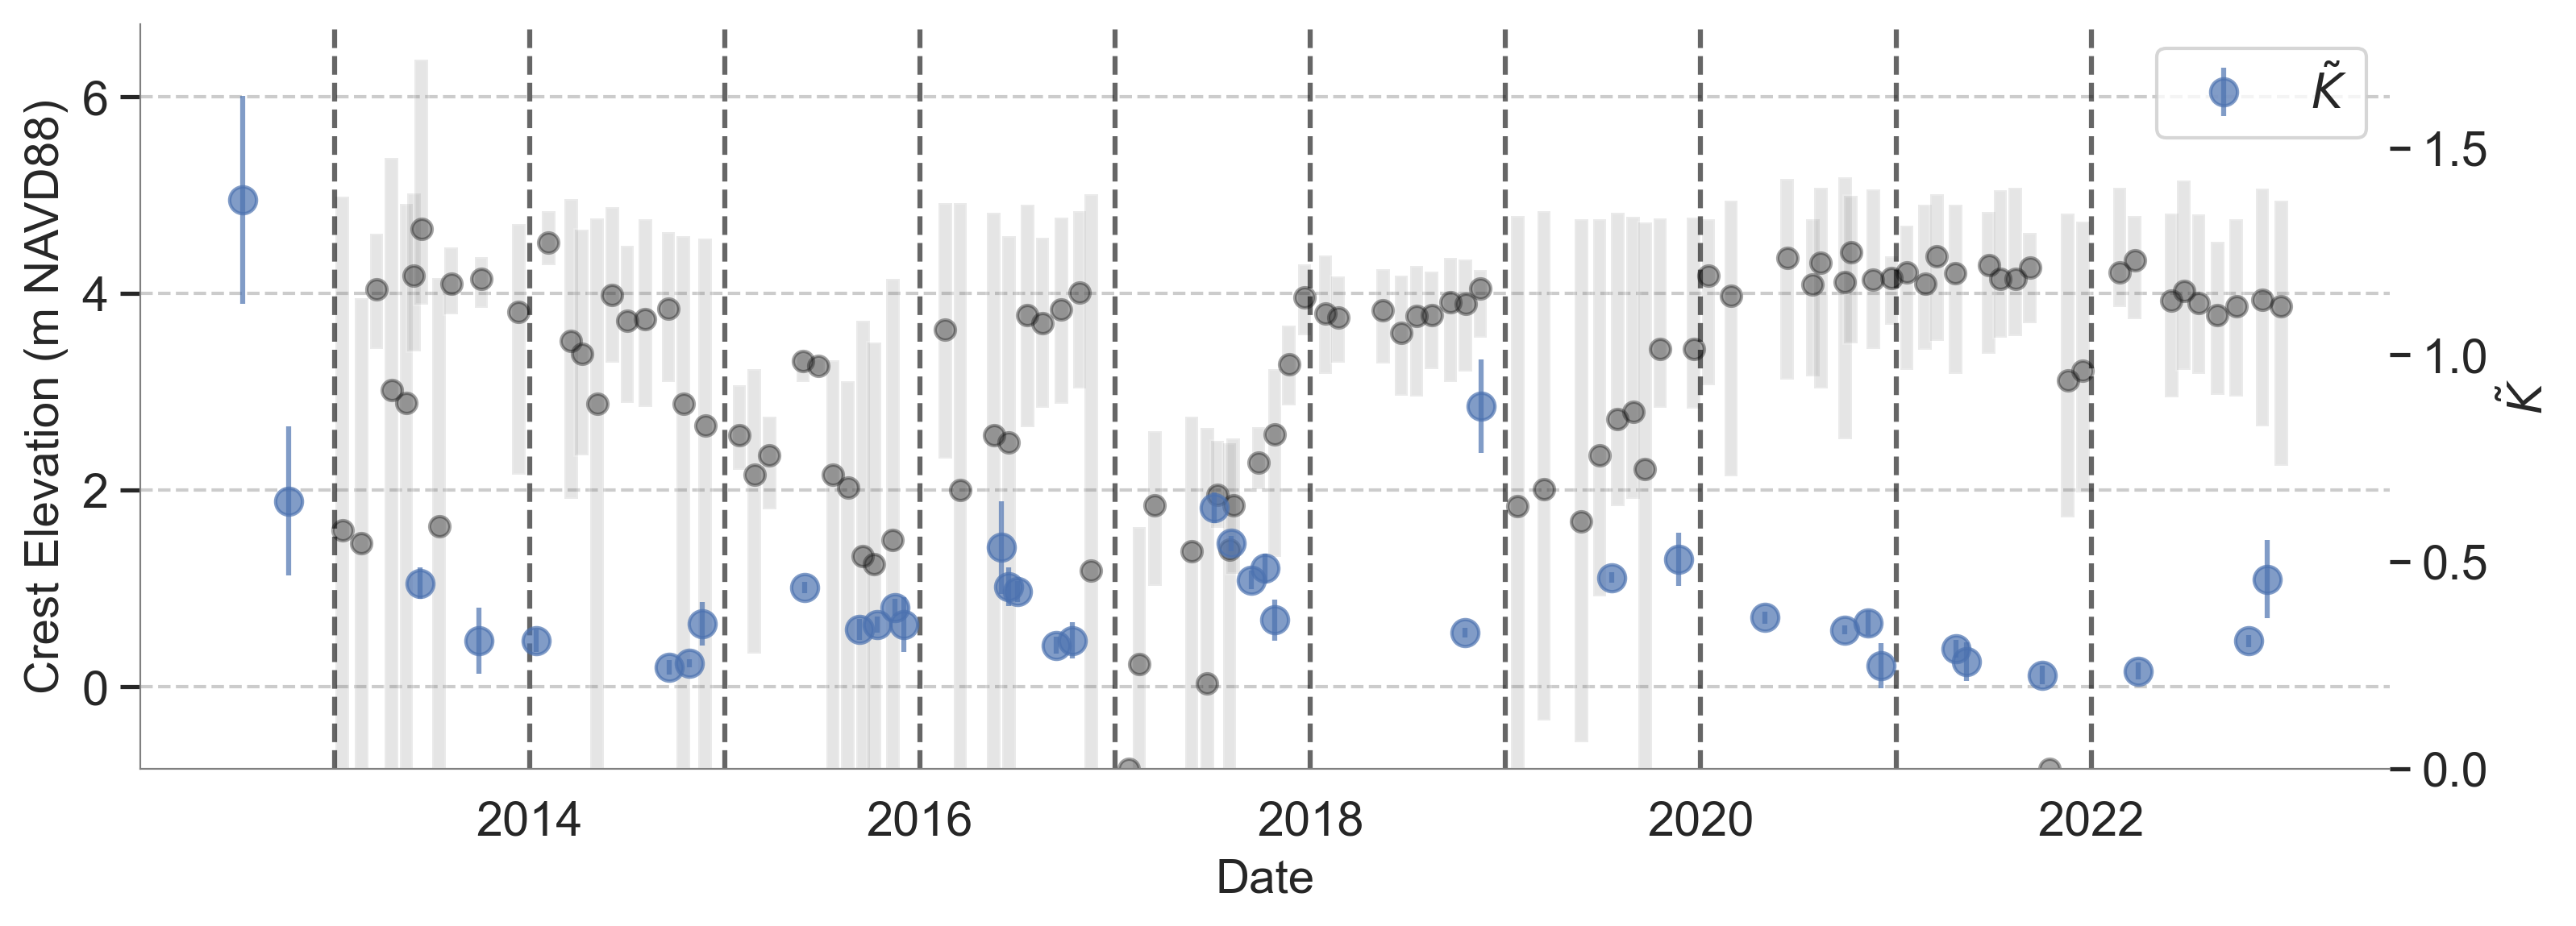

In [32]:

crest_stats = merged_df.groupby('date')['crest elev'].agg(['min', 'max', 'mean']).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot the bar for crest elevation range
ax1.bar(
    crest_stats['date'], 
    crest_stats['max'] - crest_stats['min'], 
    bottom=crest_stats['min'], 
    width=25, 
    color='grey', 
    alpha=0.2,
    label='Crest Elevation Range'
)
ax1.plot(
    crest_stats['date'], 
    crest_stats['mean'],
    'ko', 
    alpha=0.4,
    label='mean Crest Elevation'
)

# Configure primary axis for crest elevation
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Crest Elevation (m NAVD88)', fontsize=14)
# ax1.set_title('Beach Crest Elevation and Ks Over Time', fontsize=14, weight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.4)


# Add vertical lines for years
years = crest_stats['date'].dt.year.unique()
for year in years:
    ax1.axvline(pd.Timestamp(f'{year}-01-01'), color='black', linestyle='--', alpha=0.6)

# Create twin axis for Ks
ax2 = ax1.twinx()

# Add error bars to Ks values
ax2.errorbar(
    summary_pos['date'], 
    summary_pos['Ks'], 
    yerr=(summary_pos['CI_high'] - summary_pos['CI_low']) / 4,
    fmt='o', 
    ms =8, 
    color='C0', 
    alpha=.7,
    label=r'$\tilde K$'
)

# Connect Ks points in the same year with lines
summary_pos['year'] = summary_pos['date'].dt.year
for year, group in summary_pos.groupby('year'):
    ax2.plot(
        group['date'], 
        group['Ks'], 
        'C0:',  # Line style for connecting points
        alpha=0,
    )

ax2.set_ylabel(r'$\tilde K$', fontsize=14)
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.8)




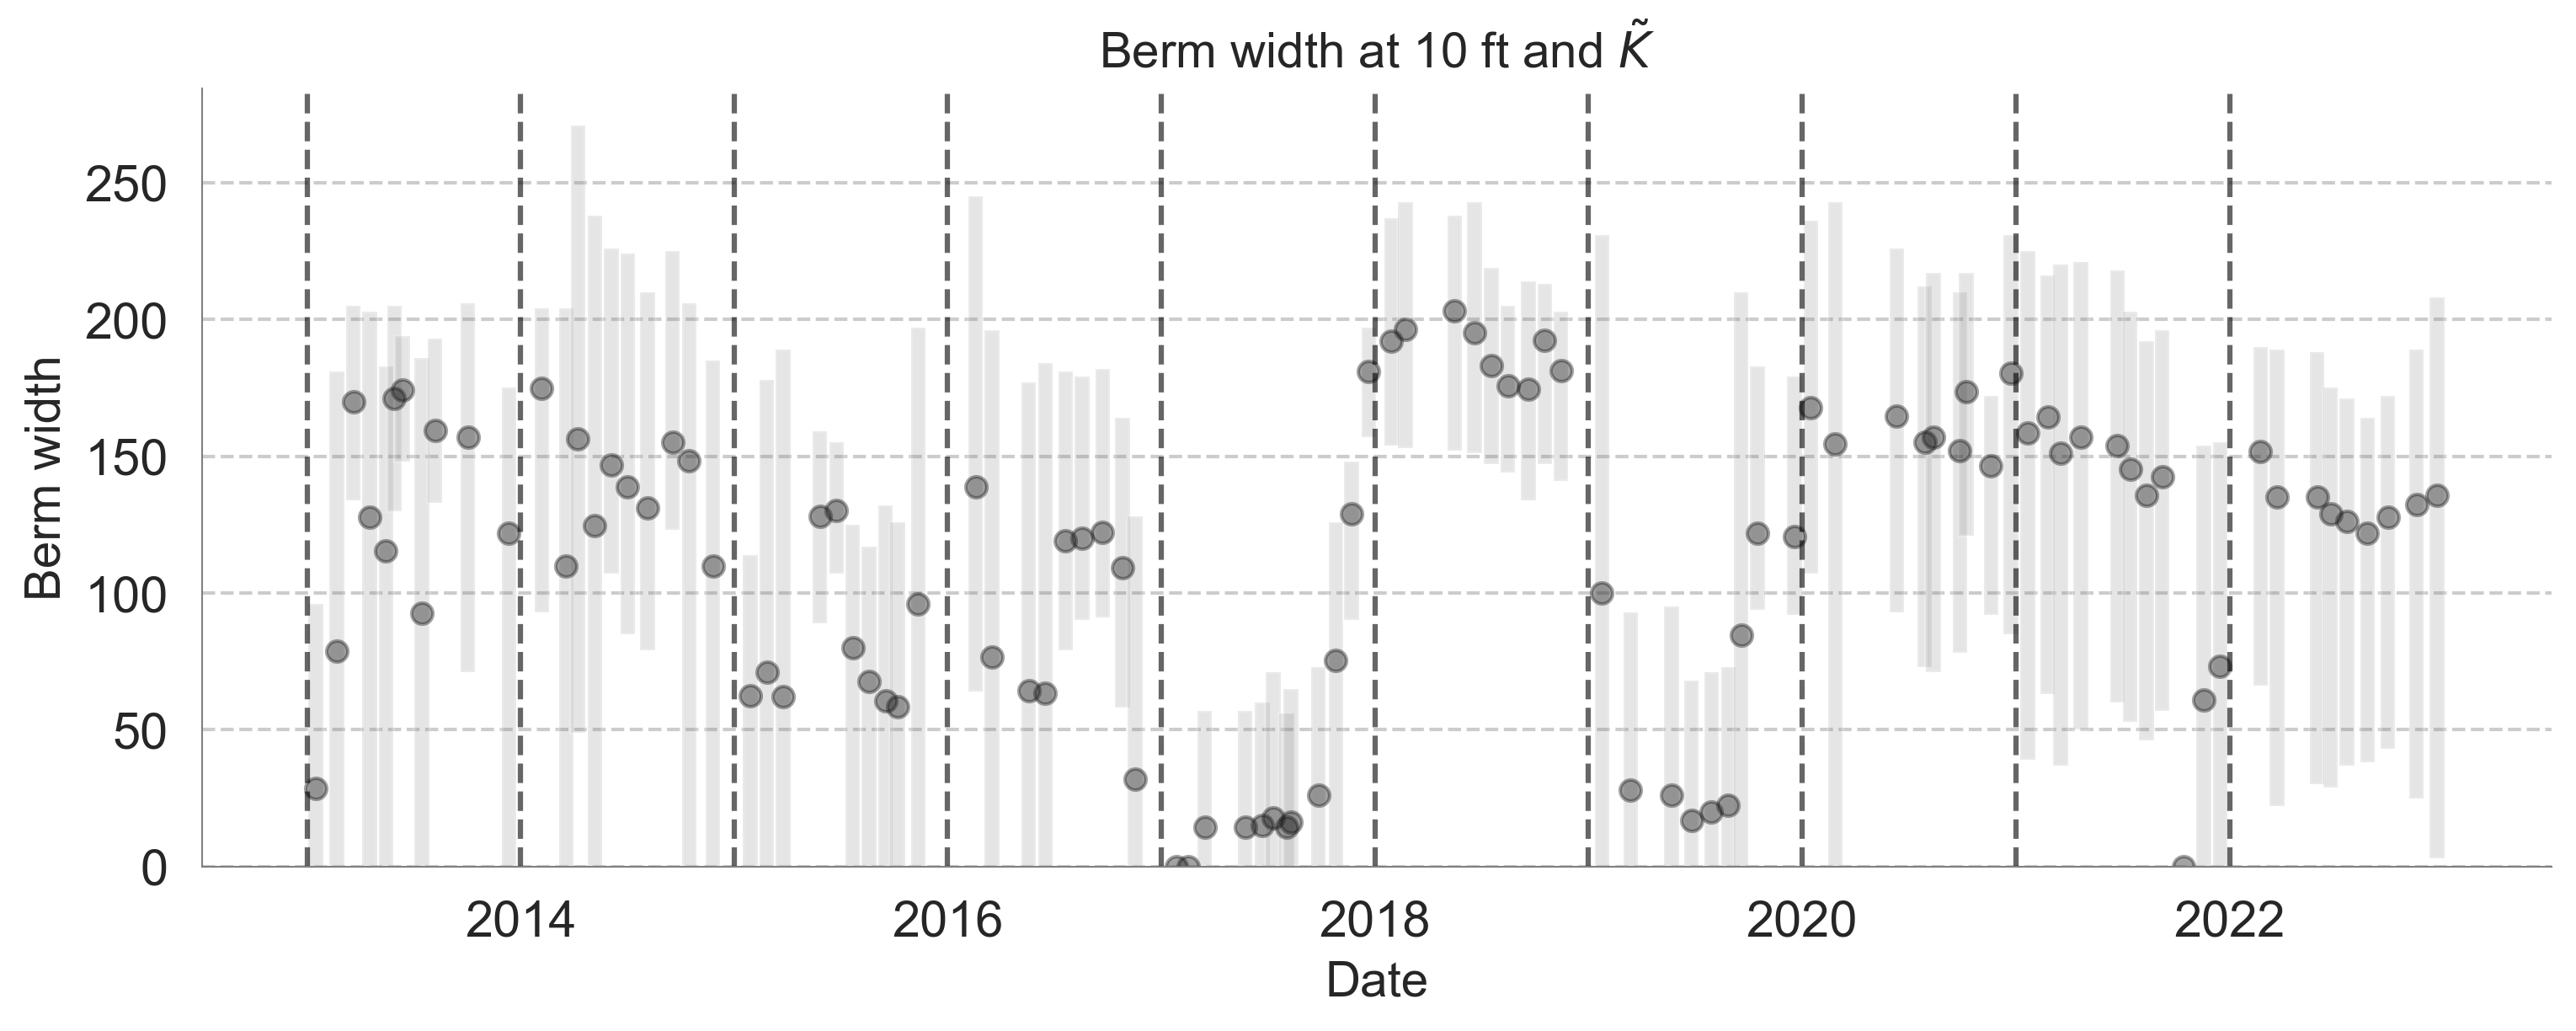

In [33]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Reload the Excel file and ensure compatibility
# file_path = 'Goat Rock beach dimensions.xlsx'
# excel_data = pd.ExcelFile(file_path)

# # Combine data from all sheets into one DataFrame
# combined_data = pd.DataFrame()

# for sheet_name in excel_data.sheet_names:
#     data = excel_data.parse(sheet_name)
#     data['Sheet'] = sheet_name[-1]  # Add a column to indicate the sheet name
#     combined_data = pd.concat([combined_data, data], ignore_index=True)

# # Convert the 'date' column to datetime format
# combined_data['date'] = pd.to_datetime(combined_data['date'])


# # Load and preprocess summary_pos data
# summary_pos_path = 'summary_pos.csv'
# summary_pos = pd.read_csv(summary_pos_path)
# summary_pos['date'] = pd.to_datetime(summary_pos['date'])

# # Perform an outer join on 'date'
# merged_df = pd.merge(combined_data, summary_pos, on='date', how='outer')

# # Compute the max, min, and mean of 'width 10' across sheets
# merged_df['width 10'] = pd.to_numeric(merged_df['width 10'], errors='coerce')
# merged_df['year'] = merged_df.date.dt.year
# merged_df = merged_df.query('year > 2012 and year < 2023')
crest_stats = merged_df.groupby('date')['width 10'].agg(['min', 'max', 'mean']).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.bar(
    crest_stats['date'], 
    crest_stats['max'] - crest_stats['min'], 
    bottom=crest_stats['min'], 
    width=25, 
    color='grey', 
    alpha=0.2
)
ax1.plot(
    crest_stats['date'], 
    crest_stats['mean'],
    'ko', 
    alpha=0.4,
    label='width 10'
)

# Configure primary axis for width 10ation
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Berm width', fontsize=14)
ax1.set_title(r'Berm width at 10 ft and $\tilde K$', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# Add vertical lines for years
years = crest_stats['date'].dt.year.unique()
for year in years:
    ax1.axvline(pd.Timestamp(f'{year}-01-01'), color='black', linestyle='--', alpha=0.6)

plot_Ks = False    
if plot_Ks:
    # Create twin axis for Ks
    ax2 = ax1.twinx()

    # Add error bars to Ks values
    ax2.errorbar(
        summary_pos['date'], 
        summary_pos['Ks'], 
        yerr=(summary_pos['CI_high'] - summary_pos['CI_low']) / 4,
        fmt='o', 
        color='C0',
        alpha = 0.8,
        ms= 8,
        label=r'$\tilde K$'
    )

# Connect Ks points in the same year with lines
summary_pos['year'] = summary_pos['date'].dt.year
for year, group in summary_pos.groupby('year'):
    ax2.plot(
        group['date'], 
        group['Ks'], 
        'C0:',  # Line style for connecting points
        alpha=0.5
    )

ax2.set_ylabel(r'$\tilde K$', fontsize=14)
ax2.legend(loc='upper left')


In [34]:
from pyproj import Transformer

# Define the transformer for NGVD29 to NAVD88
# You need the appropriate EPSG codes for NGVD29 and NAVD88 for Sonoma County
transformer = Transformer.from_crs("epsg:5714", "epsg:5703", always_xy=True)

def convert_ngvd29_to_navd88(elevation_ngvd29, latitude, longitude):
    """
    Converts elevation from NGVD29 to NAVD88.

    Parameters:
    - elevation_ngvd29: Elevation in NGVD29 (meters).
    - latitude: Latitude of the location (decimal degrees).
    - longitude: Longitude of the location (decimal degrees).

    Returns:
    - Elevation in NAVD88 (meters).
    """
    navd88_elevation = transformer.transform(longitude, latitude, elevation_ngvd29)
    return navd88_elevation

# Example conversion
latitude = 38.51  # Example latitude for Sonoma County
longitude = -122.88  # Example longitude for Sonoma County
elevation_ngvd29 = 11.0  # Example elevation in NGVD29 (meters)

r = convert_ngvd29_to_navd88(elevation_ngvd29, latitude, longitude)
# print(f"Elevation in NAVD88: {elevation_navd88:.2f} meters")


In [35]:

import pandas as pd

# Load the uploaded files
# summary_pos_path = 'summary_pos.csv'
# goat_rock_path = 'Goat Rock beach dimensions.xlsx'

# # Read the data
# summary_pos = pd.read_csv(summary_pos_path)[['date', 'Ks', 'CI_low', 'CI_high']]
# goat_rock = pd.read_excel(goat_rock_path)


transects_med = combined_data.groupby('date')\
    [['width 10', 'width 12', 'width 14', 'crest elev']].median().reset_index()
goat_rock =transects_med

# Convert the 'date' columns to datetime format
summary_pos['date'] = pd.to_datetime(summary_pos['date'])
goat_rock['date'] = pd.to_datetime(goat_rock['date'])

max_days = 14  # Maximum allowed separation in days

# Create a temporary dataframe for alignment
aligned_summary = goat_rock[['date']].copy()
aligned_summary = aligned_summary.merge(summary_pos, on='date', how='left')

# Interpolate values for missing rows within the maximum allowed separation
aligned_summary = aligned_summary.set_index('date').interpolate(method='time', limit=max_days).reset_index()

# Merge the interpolated summary data back with Goat Rock data
result = goat_rock.merge(aligned_summary, on='date', how='left')

print (result.dropna().shape)
result.dropna()[['width 10', 'width 12', 'width 14', 'crest elev', 'Ks']].corr('spearman').round(2)

(3, 36)


,width 10,width 12,width 14,crest elev,Ks
width 10,1.0,0.5,0.5,0.5,-1.0
width 12,0.5,1.0,1.0,1.0,-0.5
width 14,0.5,1.0,1.0,1.0,-0.5
crest elev,0.5,1.0,1.0,1.0,-0.5
Ks,-1.0,-0.5,-0.5,-0.5,1.0


In [36]:
merged_df = pd.merge(transects_med, summary_pos[['date', 'Ks', 'CI_low', 'CI_high']], on='date', how='outer')  # Use 'inner', 'outer', 'left', or 'right' as needed
